<a href="https://colab.research.google.com/github/cherishpresent/HeaderEditor/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.

GNN tutorial slides:
https://docs.google.com/presentation/d/1xtumYoyMyyB8Ik5fzcZNhQTtq_vzisdnR3MVBSHT5Mc/edit?usp=sharing

Install required packages

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.1+cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 24.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 25.4 MB/s eta 0:00:00


Import & Helper functions

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.data import Data
import matplotlib.pyplot as plt

In [ ]:
def visualize_graph(graph):
    vis = to_networkx(graph)
    plt.figure(1, figsize=(8, 8))
    nx.draw(vis, cmap=plt.get_cmap('Set3'),node_size=120, linewidths=13)
    plt.show()


from sklearn.manifold import TSNE
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# 1. Graph object

In [ ]:
# Define graph components
x = torch.tensor(
    [[6, 4],
     [0, 1],
     [5, 3],
     [1, 2]]
)

edge_index = torch.tensor(
    [[0, 1, 0, 2, 1, 2, 2, 3],
     [1, 0, 2, 0, 2, 1, 3, 2]]
)

edge_attr = torch.tensor(
    [[1],
     [1],
     [4],
     [4],
     [2],
     [2],
     [5],
     [5]]
)

y = torch.tensor(
    [[1],
     [0],
     [1],
     [0]]
)


graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
print(graph)

Data(x=[4, 2], edge_index=[2, 8], edge_attr=[8, 1], y=[4, 1])


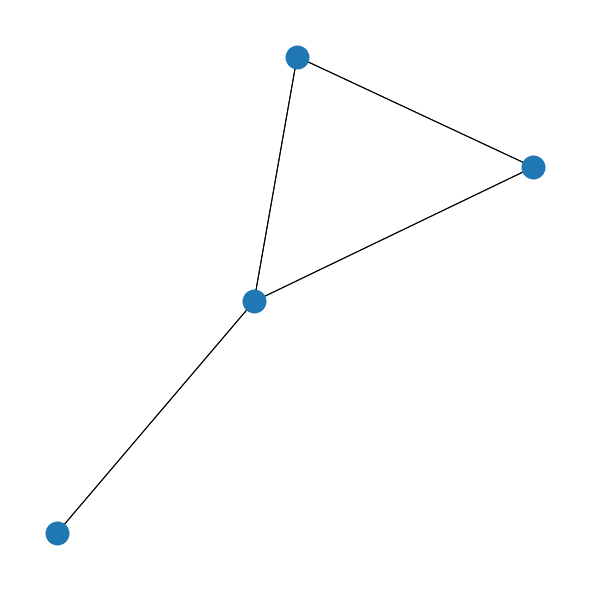

In [ ]:
# Visualize graph
visualize_graph(graph)

# 2. Message Passing

design custom message passing mechanism

In [ ]:
class self_designed_MessagePassingLayer(MessagePassing):
  def __init__(self, aggr='max'):
    super(self_designed_MessagePassingLayer, self).__init__(aggr)
    self.aggr = aggr

  def forward(self, x, edge_index):
    return self.propagate(edge_index, x=x)

  def message(self, x_i, x_j):
    return 0.5 * x_i + 2 * x_j

  def update(self, aggr_out, x):
    return x + 0.5 * aggr_out

In [ ]:
# define message passing layer
self_designed_mp_layer = self_designed_MessagePassingLayer(aggr='min')

# Go through 1 message passing:
graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
graph.x = self_designed_mp_layer(graph.x, graph.edge_index)
print(f"After 1 mp layer, graph.x =  \n{graph.x}\n")

# Go through 10 message passing:
graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
for i in range(10):
  graph.x = self_designed_mp_layer(graph.x, graph.edge_index)
print(f"After 10 mp layer, graph.x =  \n{graph.x}")

After 1 mp layer, graph.x =  
tensor([[7.5000, 6.0000],
        [5.0000, 4.2500],
        [6.2500, 4.7500],
        [6.2500, 5.5000]])

After 10 mp layer, graph.x =  
tensor([[8322.4551, 6659.8267],
        [8313.1416, 6650.5132],
        [8313.1416, 6650.5132],
        [8322.4551, 6659.8267]])


Let it learn the message passing mechanism by itself during training!

In [ ]:
class NN_MessagePassingLayer(MessagePassing):
    def __init__(self, input_dim, hidden_dim, output_dim, aggr='mean'):
        super(NN_MessagePassingLayer, self).__init__()
        self.aggr = aggr

        self.messageNN = nn.Linear(input_dim * 2, hidden_dim)
        self.updateNN = nn.Linear(input_dim + hidden_dim, output_dim)

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x, messageNN=self.messageNN, updateNN=self.updateNN)

    def message(self, x_i, x_j, messageNN):
        return messageNN(torch.cat((x_i, x_j), dim=-1))

    def update(self, aggr_out, x, updateNN):
        return updateNN(torch.cat((x, aggr_out), dim=-1))

# 3. GNN model & Case study

### 3.1 GNN model

In [ ]:
class myGNN(torch.nn.Module):
    def __init__(self, layer_num, input_dim, hidden_dim, output_dim, aggr='mean', **kwargs):
        super(myGNN, self).__init__()
        self.layer_num = layer_num

        self.encoder = nn.Linear(input_dim, hidden_dim)

        # you can use the message passing layer you like, such as GCN, GAT, ......
        self.mp_layer = NN_MessagePassingLayer(input_dim=hidden_dim, hidden_dim=hidden_dim,
                                               output_dim=hidden_dim, aggr=aggr)

        self.decoder = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.encoder(x)
        for i in range(self.layer_num):
            x = self.mp_layer(x, edge_index)
        node_out = self.decoder(x)
        return node_out


### 3.2 Case study

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

graph = dataset[0]  # Get the first graph object.

print()
print(graph)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {graph.num_nodes}')
print(f'Number of edges: {graph.num_edges}')
print(f'Average node degree: {graph.num_edges / graph.num_nodes:.2f}')
print(f'Number of training nodes: {graph.train_mask.sum()}')
print(f'Training node label rate: {int(graph.train_mask.sum()) / graph.num_nodes:.2f}')
print(f'Has isolated nodes: {graph.has_isolated_nodes()}')
print(f'Has self-loops: {graph.has_self_loops()}')
print(f'Is undirected: {graph.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Processing...
Done!


Train a Multi-layer Perceptron...

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(input_dim=dataset.num_features,
            hidden_dim=16,
            output_dim=dataset.num_classes)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(graph.x)  # Perform a single forward pass.
      loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(graph.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[graph.test_mask] == graph.y[graph.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(graph.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


Test Accuracy: 0.5670



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


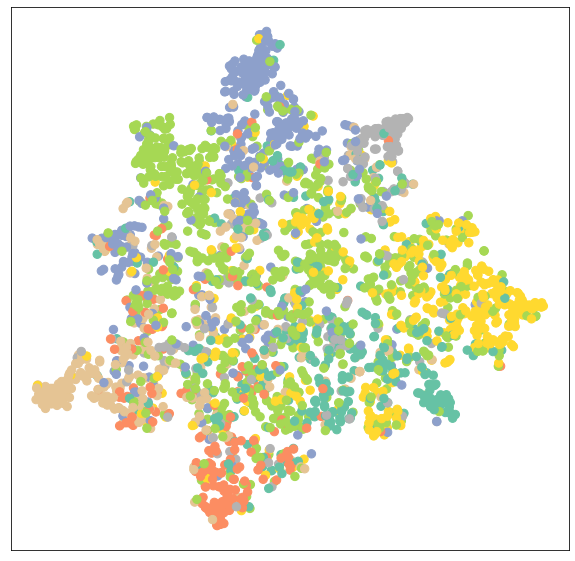

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}\n')

model.eval()
out = model(graph.x)
visualize(out, color=graph.y)

Train a Graph Neural Network...

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = torch_geometric.nn.GCNConv(input_dim, hidden_dim, aggr='add')
        self.conv2 = torch_geometric.nn.GCNConv(hidden_dim, output_dim, aggr='add')

    def forward(self, x, edge_index):
        print(x.shape)
        print(edge_index.shape)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(input_dim=dataset.num_features,
            hidden_dim=16,
            output_dim=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(graph.x, graph.edge_index)  # Perform a single forward pass.
      loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(graph.x, graph.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[graph.test_mask] == graph.y[graph.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(graph.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

torch.Size([2708, 1433])
torch.Size([2, 10556])
Epoch: 001, Loss: 1.9460
torch.Size([2708, 1433])
torch.Size([2, 10556])
Epoch: 002, Loss: 1.9412
torch.Size([2708, 1433])
torch.Size([2, 10556])
Epoch: 003, Loss: 1.9363
torch.Size([2708, 1433])
torch.Size([2, 10556])
Epoch: 004, Loss: 1.9308
torch.Size([2708, 1433])
torch.Size([2, 10556])
Epoch: 005, Loss: 1.9216
torch.Size([2708, 1433])
torch.Size([2, 10556])
Epoch: 006, Loss: 1.9137
torch.Size([2708, 1433])
torch.Size([2, 10556])
Epoch: 007, Loss: 1.9078
torch.Size([2708, 1433])
torch.Size([2, 10556])
Epoch: 008, Loss: 1.8986
torch.Size([2708, 1433])
torch.Size([2, 10556])
Epoch: 009, Loss: 1.8868
torch.Size([2708, 1433])
torch.Size([2, 10556])
Epoch: 010, Loss: 1.8825
torch.Size([2708, 1433])
torch.Size([2, 10556])
Epoch: 011, Loss: 1.8701
torch.Size([2708, 1433])
torch.Size([2, 10556])
Epoch: 012, Loss: 1.8614
torch.Size([2708, 1433])
torch.Size([2, 10556])
Epoch: 013, Loss: 1.8486
torch.Size([2708, 1433])
torch.Size([2, 10556])
Epo

Test Accuracy: 0.8150



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


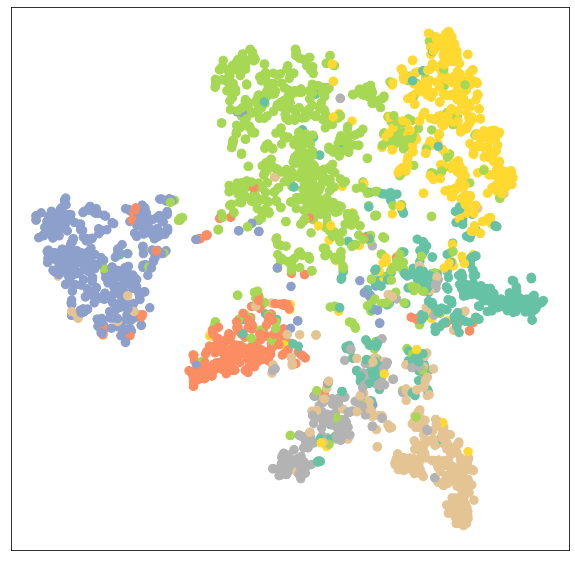

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}\n')

model.eval()
out = model(graph.x, graph.edge_index)
visualize(out, color=graph.y)